# Preparation of Data

In [1]:
import fitsio as ft
import healpy as hp
import pandas as pd
import numpy as np
import sys
sys.path.insert(0, '/home/mehdi/github/LSSutils')
from lssutils.utils import hpix2radec, split_jackknife_strip

%matplotlib inline
import matplotlib.pyplot as plt

Read appropriate columns

In [2]:
# read imaging
dt = pd.read_hdf('/home/mehdi/data/templates/dr8pixweight-0.32.0_combined256.h5')
dr8_cols = ['ebv', 'loghi', 'nstar',
            'depth_r_total', 'depth_g_total', 'depth_z_total',
             'fwhm_r_mean', 'fwhm_g_mean', 'fwhm_z_mean',
            'airmass_r_mean', 'airmass_g_mean', 'airmass_z_mean',
            'ccdskymag_r_mean', 'ccdskymag_g_mean', 'ccdskymag_z_mean',
             'exptime_r_total', 'exptime_g_total', 'exptime_z_total',
             'mjd_r_min', 'mjd_g_min', 'mjd_z_min', 
            'galdepth_g','galdepth_r', 'galdepth_z', 
            'psfsize_g', 'psfsize_r', 'psfsize_z']
features = dt[dr8_cols].values

In [3]:
# read data and randoms
ngal = hp.read_map('/home/mehdi/data/tanveer/elg_gal256.fits', verbose=False, dtype=np.float64)
nran = hp.read_map('/home/mehdi/data/tanveer/elg_ran256.fits', verbose=False, dtype=np.float64)
frac = nran / nran[nran > 0].mean()

/home/mehdi/miniconda3/envs/sysnet/lib/python3.8/site-packages/healpy/fitsfunc.py:351: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(
/home/mehdi/miniconda3/envs/sysnet/lib/python3.8/site-packages/healpy/fitsfunc.py:351: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(


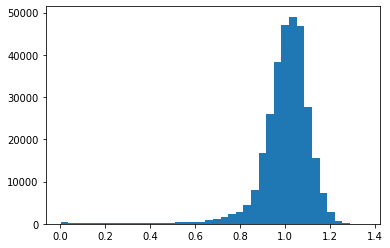

In [4]:
_ = plt.hist(frac[nran>0], bins=40)

In [7]:
mask = frac > 0.2
npix = mask.sum()
nsys = features.shape[1]
print(f'npix: {npix}, nsys: {nsys}')
isgood = np.isfinite(features).sum(axis=1) == nsys
mask = mask & isgood
npix = mask.sum()
print(f'npix: {npix}, nsys: {nsys}')

npix: 302795, nsys: 27
npix: 302503, nsys: 27


In [8]:
data = np.zeros(npix, dtype=[('label', 'f8'),
                             ('features', 'f8', nsys),
                             ('hpix', 'i8'),
                             ('fracgood', 'f8')])

data['label'] = ngal[mask]
data['fracgood'] = frac[mask]
data['features'] = features[mask, :]
data['hpix'] = np.argwhere(mask).flatten()

In [10]:
for ni in data.dtype.names:
    print((~np.isfinite(data[ni])).sum(), ni)

0 label
0 features
0 hpix
0 fracgood


In [12]:
ft.write('/home/mehdi/data/tanveer/dr8_elg_0.32.0_256.fits', data, clobber=True)

In [11]:
for i in range(data['features'].shape[1]):
    print(np.std(data['features'][:, i]), i)

0.0324522365999097 0
0.24676607647539517 1
550.9678470423167 2
0.5453596961046706 3
0.460072950968793 4
0.3398449458209416 5
0.4861657472377818 6
0.4330989076953627 7
0.2951514697330035 8
0.2735265257649082 9
0.2676904587698299 10
0.29974618479927223 11
0.5325523954193835 12
0.44819525802087906 13
0.32808173722527234 14
9030.468845016689 15
10422.278171963622 16
19097.314448930163 17
548.7131457853025 18
505.768741111331 19
475.1770182805158 20
0.26292189723357745 21
0.3651981766127112 22
0.1942551042540837 23
0.26579899443464733 24
0.2388452860229008 25
0.17912486892118784 26


Split into Jackknifes

In [2]:
data = ft.read('/home/mehdi/data/tanveer/dr8_elg_0.32.0_256.fits')
data.size

302503

In [4]:
njack = 25
indices_raw = np.arange(data['hpix'].size)
chunks = split_jackknife_strip(indices_raw, data['fracgood'], njack=njack)

In [5]:
for i, chunk in enumerate(chunks[0]):
    print(i, np.sum(data['fracgood'][chunk]))
    if i > 5:break

0 12160.160191454803
1 12160.829932540815
2 12160.262912480264
3 12160.41493959795
4 12161.002503863594
5 12161.027156909702
6 12160.406721915911


In [6]:
np.concatenate(chunks[0]).size

302503

In [6]:
jkindices = []
for i in range(len(chunks[0])):
    
    indices_ = chunks[0].copy()
    indices_.pop(i)
    
    jkindices.append(np.concatenate(indices_))    

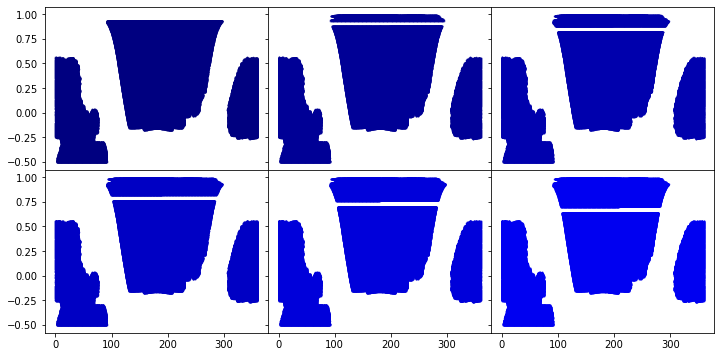

In [14]:
fig, ax = plt.subplots(ncols=3, nrows=2, 
                       figsize=(12, 6), 
                       sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.0, hspace=0.0)
ax = ax.flatten()

for i, jack in enumerate(jkindices):
    
    myhpix = data['hpix'][jack]
    ra, dec = hpix2radec(256, myhpix)
    
    ax[i].scatter(ra, np.sin(np.deg2rad(dec)), 1, alpha=0.4, color=plt.cm.jet(i/50))
    if i > 4:break

In [12]:
!mkdir -p /home/mehdi/data/tanveer/jackknife/25/

In [15]:
for i, jack in enumerate(jkindices):  

    mydata = data[jack]
    ft.write(f'/home/mehdi/data/tanveer/jackknife/25/dr8jk{i}_elg_0.32.0_256.fits', mydata, clobber=True)

In [16]:
ls /home/mehdi/data/tanveer/jackknife/25/

dr8jk0_elg_0.32.0_256.fits   dr8jk21_elg_0.32.0_256.fits
dr8jk10_elg_0.32.0_256.fits  dr8jk22_elg_0.32.0_256.fits
dr8jk11_elg_0.32.0_256.fits  dr8jk23_elg_0.32.0_256.fits
dr8jk12_elg_0.32.0_256.fits  dr8jk24_elg_0.32.0_256.fits
dr8jk13_elg_0.32.0_256.fits  dr8jk2_elg_0.32.0_256.fits
dr8jk14_elg_0.32.0_256.fits  dr8jk3_elg_0.32.0_256.fits
dr8jk15_elg_0.32.0_256.fits  dr8jk4_elg_0.32.0_256.fits
dr8jk16_elg_0.32.0_256.fits  dr8jk5_elg_0.32.0_256.fits
dr8jk17_elg_0.32.0_256.fits  dr8jk6_elg_0.32.0_256.fits
dr8jk18_elg_0.32.0_256.fits  dr8jk7_elg_0.32.0_256.fits
dr8jk19_elg_0.32.0_256.fits  dr8jk8_elg_0.32.0_256.fits
dr8jk1_elg_0.32.0_256.fits   dr8jk9_elg_0.32.0_256.fits
dr8jk20_elg_0.32.0_256.fits


# 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import healpy as hp
import fitsio as ft

import sys
sys.path.insert(0, '/home/mehdi/github/LSSutils')
from lssutils.utils import hpixsum, make_overdensity, hpix2radec
from lssutils.stats.cl import AnaFast
from lssutils.stats.nnbar import MeanDensity

In [2]:
class GenSys:
    def __init__(self, weightfile, nside=256):        
        self.npred_ = ft.read(weightfile)
        self.mask_ = np.zeros(12*nside*nside, '?')
        self.mask_[self.npred_['hpix']] = True
        print('# of selection functions: ', self.npred_['weight'].shape)

    def __call__(self, ix, dat, ran, mask, delta):
        
        npred = np.zeros_like(dat)
        if len(self.npred_['weight'].shape) > 1:
            wnn_ix = self.npred_['weight'][:, ix]
        else:
            wnn_ix = self.npred_['weight']
            
        wnn_ix = wnn_ix / wnn_ix.mean()
        wnn_ix = wnn_ix.clip(0.5, 2.0)
        
        npred[self.npred_['hpix']] = wnn_ix

        mask_comm = mask & self.mask_
        #norm_fact = dat[mask_comm].sum()/(dat[mask_comm]*npred[mask_comm]).sum()
        #norm_fact = np.std(delta[mask_comm])/np.std(delta[mask_comm]*npred[mask_comm])
        #npred *= norm_fact
        
        
        delta_cont = delta.copy()
        delta_cont[mask_comm] = delta_cont[mask_comm]*npred[mask_comm] + (npred[mask_comm]-1.0)
        return delta_cont        

In [3]:
dat_ = ft.read('/home/mehdi/data/tanveer/FA_EZmock_desi_ELG_v0_10.fits')

dat = hpixsum(256, dat_['RA'], dat_['DEC'])*1.0
ran = hp.read_map('/home/mehdi/data/tanveer/FA_EZmock_desi_ELG_v0_rand_00to2.hp256.fits', 
                  verbose=False, dtype=np.float64)*1.0
mask = ran > 0

delta_clean = make_overdensity(dat, ran, mask) # clean delta

In [4]:
#gensys = GenSys('/home/mehdi/data/tanveer/elg_mse/nn-weights.fits')
gensys = GenSys('/home/mehdi/data/tanveer/elg_mse_jk/nn-weights-combined.fits')

# of selection functions:  (302503, 125)


In [5]:
af = AnaFast()

results = {}
results['before'] = af(delta_clean, ran, mask)

for ix in range(125):
    delta_ix = gensys(ix, dat, ran, mask, delta_clean)
    results[f'after_{ix}'] = af(delta_ix, ran, mask)
    print('.', end='')

.............................................................................................................................

In [15]:
# linear
# gensys2 = GenSys('/home/mehdi/data/tanveer/elg_lin/nn-weights.fits')
# af = AnaFast()

# results2 = {}

# #results['before'] = af(delta_clean, ran, mask)
# delta_ix = gensys2(0, dat, ran, mask, delta_clean)
# results2[f'after_lin'] = af(delta_ix, ran, mask)

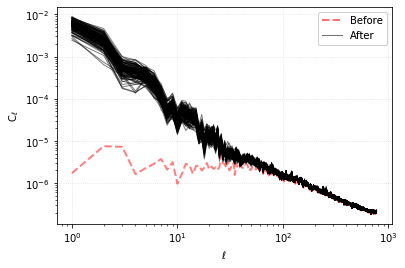

In [8]:
fig, ax = plt.subplots()


for ni, cli in results.items():
    ls = 'k-' if 'after' in ni else 'r--'
    lw = 2.0 if ni=='before' else 1.0    
    ax.plot(cli['l'][1:], cli['cl'][1:], ls, lw=lw, alpha=0.5)    
        
#ax.plot(results2['after_lin']['l'][1:], results2['after_lin']['cl'][1:], 'b-.')    # linear
    
lines = ax.get_lines()
lgnd = plt.legend(lines[:2], ['Before', 'After'])
fig.add_artist(lgnd)

ax.set(xscale='log', yscale='log', ylabel=r'C$_{\ell}$', xlabel=r'$\ell$')
ax.grid(True, ls=':', alpha=0.4)
fig.savefig('cl_before_after_delta_jk.png', dpi=300, bbox_inches='tight')

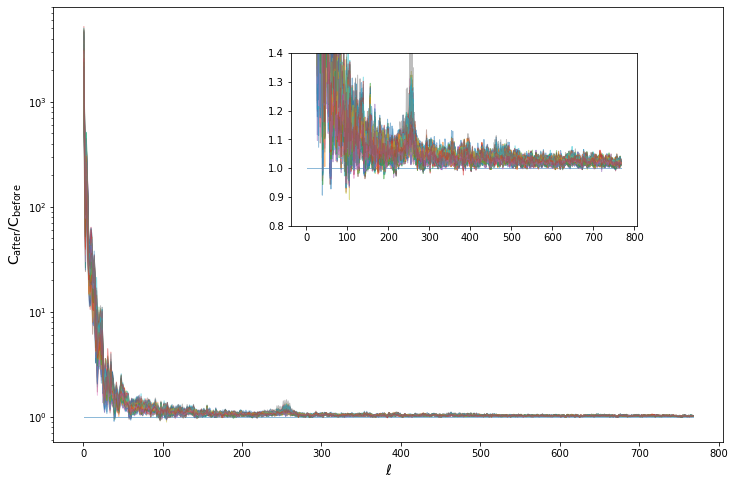

In [9]:
plt.figure(figsize=(12, 8))
for ni, cli in results.items():    
    plt.plot(cli['l'][1:], cli['cl'][1:]/results['before']['cl'][1:], 
            lw=1, alpha=0.5)
plt.yscale('log')    
plt.xlabel(r'$\ell$', fontsize=14)
plt.ylabel(r'C$_{\rm after}$/C$_{\rm before}$', fontsize=14)

plt.axes([0.4, 0.5, 0.4, 0.3])
for ni, cli in results.items():    
    plt.plot(cli['l'][1:], cli['cl'][1:]/results['before']['cl'][1:], 
            lw=1, alpha=0.5) 
plt.ylim(0.8, 1.4)


plt.savefig('cl_before_after_ratio_jk.png', dpi=300, bbox_inches='tight')

In [10]:
cl_ = []
for ni in results:
    if not 'after' in ni:
        continue        
    cli = results[ni]['cl'][1:]
    cl_.append(cli)
    
cl_ = np.array(cl_)    

In [11]:
cl_.shape

(125, 767)

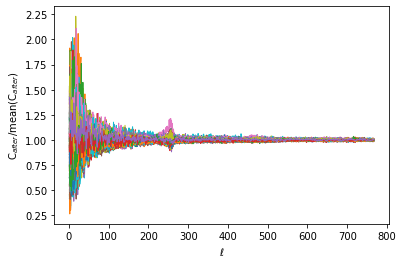

In [12]:
cl_m = cl_.mean(axis=0)

for i in range(125):
    plt.plot(np.arange(1, 768), cl_[i, :]/cl_m, lw=1)

plt.xlabel(r'$\ell$')
plt.ylabel(r'C$_{after}$/mean(C$_{after}$)')
plt.savefig('cl_ratio_realizations_jk.png', dpi=300, bbox_inches='tight')

In [41]:
from lssutils.dataviz import mollview, mycolor

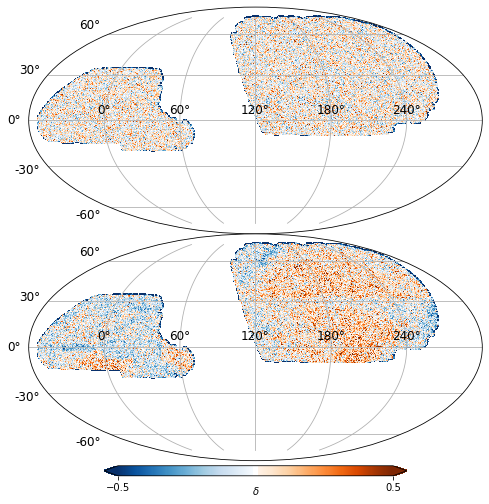

In [42]:
unit = r'$\delta$'
vmin = -0.5
vmax = 0.5

fig = plt.figure(figsize=(7, 7))
# matplotlib is doing the mollveide projection
ax  = fig.add_subplot(211, projection='mollweide')
ax1 = fig.add_subplot(212, projection='mollweide')
spacing = 0.05
plt.subplots_adjust(bottom=spacing, top=1-spacing, 
                    left=spacing, right=1-spacing,
                    hspace=0.0, wspace=0.0)


mollview(delta_clean, vmin, vmax, unit, figax=[fig, ax], cmap=mycolor())
mollview(delta_ix, vmin, vmax, unit, figax=[fig, ax1], cmap=mycolor(), colorbar=True)
fig.savefig('delta_before_after_delta.png', dpi=300, bbox_inches='tight')

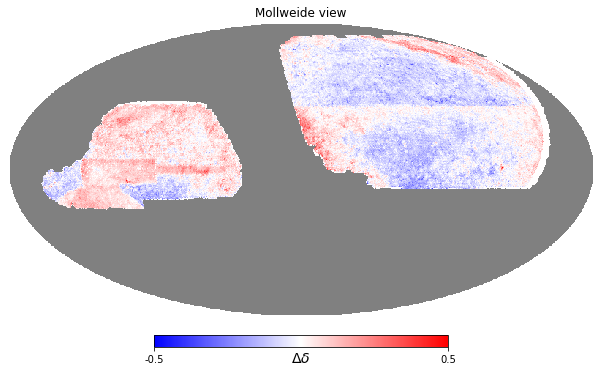

In [48]:
hp.mollview(delta_clean - delta_ix, min=-0.5, max=0.5, 
            cmap=plt.cm.bwr, unit=r'$\Delta \delta$', rot=+270)